In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fields import Fields
from fisher import Fisher
from scipy.interpolate import InterpolatedUnivariateSpline
from cosmology import Cosmology
from powerspectra import Powerspectra
from covariance import Covariance
from scipy import stats, signal
import copy
import time

In [2]:
omega_Ls, omega_ps = Cosmology().get_postborn_omega_ps(10000)

In [3]:
fish = Fisher()
def get_F_L_and_C_inv_splines(fields, Lmax=5000): 
    sample_Ls = fish.covariance.get_log_sample_Ls(Lmin=2, Lmax=Lmax, Nells=150)
    print(np.max(sample_Ls))
    sample_Ls, F_L, C_inv = fish.get_F_L(fields, Ls=sample_Ls, Ntheta=100, nu=353e9, return_C_inv=True)
    F_L_spline = InterpolatedUnivariateSpline(sample_Ls, F_L)
    N_fields = np.size(fields)
    C_inv_splines = np.empty((N_fields, N_fields), dtype=InterpolatedUnivariateSpline)
    Ls = np.arange(Lmax+1)
    for iii in range(N_fields):
        for jjj in range(N_fields):
            C_inv_ij = C_inv[iii, jjj]
            C_inv_splines[iii, jjj] = InterpolatedUnivariateSpline(Ls[2:], C_inv_ij[2:])
    return F_L_spline, C_inv_splines

In [26]:
fields = "k"
fields = np.char.array(list(fields))
%time F_L_spline_k, C_inv_spline_k = get_F_L_and_C_inv_splines(fields)
fields = "g"
fields = np.char.array(list(fields))
%time F_L_spline_g, C_inv_spline_g = get_F_L_and_C_inv_splines(fields)

5000.0
CPU times: user 57.8 s, sys: 5.79 s, total: 1min 3s
Wall time: 30.7 s
5000.0
CPU times: user 2min 44s, sys: 39 s, total: 3min 23s
Wall time: 58.3 s


In [27]:
F_L_spline, C_inv_spline = F_L_spline_k, C_inv_spline_k

In [6]:
class OmegaQE_noCache:
    
    def __init__(self, field_labels, N_pix=2 ** 7, Lmax=5000, kappa_map=None):
        self._power = Powerspectra()
        self._cosmo = Cosmology()
        self._fish = Fisher()
        self.fish = self._fish
        self.N_pix = N_pix
        self.fields = Fields(field_labels, "SO", N_pix, Lmax, kappa_map)
        self.L_map = self.fields.kM
        self.Lx_map , self.Ly_map = self.get_Lx_Ly_maps()
        self.F_L_spline, self.C_inv_spline = F_L_spline, C_inv_spline
        
    def _get_Cl_and_window(self, Chi, field, nu=353e9, gal_distro="LSST_gold"):
        shape_1, shape_2 = np.shape(self.L_map)
        if field == "k":
            Cl = self._power.get_kappa_ps_2source(self.L_map.flatten(), Chi, self._cosmo.get_chi_star(), use_weyl=False)
            Cl = np.reshape(Cl, (shape_1, shape_2))
            window = self._cosmo.cmb_lens_window_matter(Chi, self._cosmo.get_chi_star(), False)
            return Cl, window
        if field == "g":
            Cl =  self._power.get_gal_kappa_ps(self.L_map.flatten(), Chi, gal_distro=gal_distro, use_weyl=False)
            Cl = np.reshape(Cl, (shape_1, shape_2))
            window = self._cosmo.gal_window_Chi(Chi)
            return Cl, window
        if field == "I":
            Cl =  self._power.get_cib_kappa_ps(self.L_map.flatten(), nu=nu, Chi_source1=Chi, use_weyl=False)
            Cl = np.reshape(Cl, (shape_1, shape_2))
            window = self._cosmo.cib_window_Chi(Chi, nu)
            return Cl, window
    
        
    def get_Lx_Ly_maps(self):
        Lx, Ly = self.fields.get_kx_ky()
        Lx_map = Lx[None, :] * np.ones(np.shape(self.fields.kM))
        Ly_map = Ly[:, None] * np.ones(np.shape(self.fields.kM))
        return Lx_map, Ly_map
    
    def L_comp_map(self, index):
        if index == 0:
            return self.Lx_map
        if index == 1:
            return self.Ly_map
    
    def _get_matter_ps(self, Chis):
        Chis = Chis[None, None, :]
        Ls = self.L_map[:, :, None]
        zs = self._cosmo.Chi_to_z(Chis)
        ks = Ls / Chis
        matter_PK = self._cosmo.get_matter_PK(typ="matter")
        matter_ps = self._cosmo.get_matter_ps(matter_PK, zs, ks, weyl_scaled=False, typ="matter")
        return matter_ps
    
    def get_L_fac(self, p, r):
        L_p = self.L_comp_map(p)
        L_r = self.L_comp_map(r)
        return L_p*L_r/((self.L_map+0.5)**2)
    
    def get_f_g(self, p, r, q, s, Chi_i, Chi, noise):
        L_fac_f = self.get_L_fac(p, r)
        L_fac_g = self.get_L_fac(q, s)
        C_inv_spline = self.C_inv_spline
        Cls = dict.fromkeys(self.fields.fields)
        windows = dict.fromkeys(self.fields.fields)
        for field in self.fields.fields:
            Cls[field], windows[field] = self._get_Cl_and_window(Chi,field) 
        h_f = 0
        h_g = 0
        for iii, field_i in enumerate(self.fields.fields):
            for jjj, field_j in enumerate(self.fields.fields):
                if noise:
                    a_j = copy.deepcopy(self.fields.fft_maps[field_j]) + copy.deepcopy(self.fields.fft_noise_maps[field_j])
                else:
                    a_j = copy.deepcopy(self.fields.fft_maps[field_j])
                h_f += windows[field_i] * a_j * C_inv_spline[iii,jjj](self.L_map)
                h_g += Cls[field_i] * a_j * C_inv_spline[iii,jjj](self.L_map)
        return L_fac_f * h_f * self.matter_ps[:,:,Chi_i], L_fac_g * h_g
    
    def get_omega(self, Nchi=20, noise=False, norm="forward"):
        Lx, Ly = self.fields.get_kx_ky()

        Chis = np.linspace(0, self._cosmo.get_chi_star(), Nchi)[1:]
        dChi = Chis[1] - Chis[0]
        self.matter_ps = self._get_matter_ps(Chis)
        I = np.zeros((np.shape(self.L_map)), dtype="complex128")
        r=1
        s=0
        for Chi_i, Chi in enumerate(Chis):
            window_k = self._cosmo.cmb_lens_window_matter(Chi, self._cosmo.get_chi_star(), False)
            I_tmp = np.zeros((np.shape(self.L_map)), dtype="complex128")
            for p in range(2):
                q = p
                f_i, g_j = self.get_f_g(p,r,q,s,Chi_i, Chi, noise)
                f_j, g_i = self.get_f_g(q,s,p,r,Chi_i, Chi, noise)
                F_i = np.fft.irfft2(f_i, norm=norm)
                G_j = np.fft.irfft2(g_j, norm=norm)
                F_j = np.fft.irfft2(f_j, norm=norm) 
                G_i = np.fft.irfft2(g_i, norm=norm)
                I_tmp += 2* np.fft.rfft2((F_i*G_j) - (F_j*G_i), norm=norm)
            I += I_tmp/(Chi**2) * window_k *dChi/((2*np.pi)**2) *Lx[1]*Ly[1]
        return I/self.F_L_spline(self.L_map)


In [11]:
def get_ps(omega, qe):
    nBins=50
    ps = np.real(np.conjugate(omega) * omega)
    ps[qe.N_pix // 2 + 1:, 0] /= 2
    ps[qe.N_pix // 2 + 1:, -1] /= 2
    means, bin_edges, binnumber = stats.binned_statistic(qe.L_map.flatten(), ps.flatten(), 'mean', bins=nBins)
    binSeperation = bin_edges[1]
    kBins = np.asarray([bin_edges[i] - binSeperation / 2 for i in range(1, len(bin_edges))])
    return means, kBins

In [12]:
def get_omega(field, N_pix_power):
    qe = OmegaQE_noCache(field, N_pix=2**N_pix_power)
    Lx, Ly = qe.fields.get_kx_ky()
    print(f"Lmin = {Lx[1]}")
    return get_ps(qe.get_omega(100, norm="forward", noise=True), qe)

In [13]:
%time omega_k_7, kBins_7 = get_omega("k",7)
%time omega_k_8, kBins_8 = get_omega("k",8)

Lmin = 55.242717280199024
CPU times: user 8min 14s, sys: 1min 46s, total: 10min 1s
Wall time: 1min 51s
Lmin = 27.621358640099512
CPU times: user 13min 8s, sys: 3min 14s, total: 16min 22s
Wall time: 5min 4s


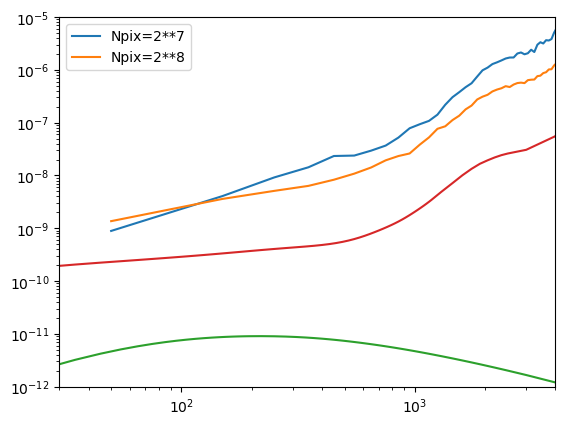

In [15]:
plt.loglog(kBins_7[:], omega_k_7[:], label="Npix=2**7")
plt.loglog(kBins_8[:], omega_k_8[:], label="Npix=2**8")
plt.loglog(omega_Ls, omega_ps)
plt.loglog(omega_Ls, omega_ps/F_L_spline(omega_Ls))
plt.xlim(3e1, 4e3)
plt.ylim(1e-12,1e-5)
plt.legend()

In [60]:
%time omega_k_9, kBins_9 = get_omega("k",9)

Lmin = 13.810679320049756
CPU times: user 27min 42s, sys: 44.2 s, total: 28min 26s
Wall time: 18min 14s


In [78]:
%time omega_k_10, kBins_10 = get_omega("k",10)

Lmin = 6.905339660024878
CPU times: user 1h 15min 1s, sys: 3min 5s, total: 1h 18min 7s
Wall time: 1h 9min 53s


In [82]:
%time omega_k_11, kBins_11 = get_omega("k",11)

Lmin = 3.452669830012439
CPU times: user 4h 35min 4s, sys: 18min 45s, total: 4h 53min 50s
Wall time: 4h 53min 1s


In [105]:
np.mean(omega_k_10/omega_k_11)

3.910397532887616

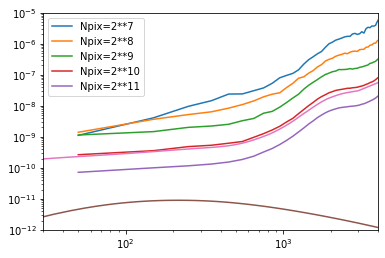

In [110]:
plt.loglog(kBins_7[:], omega_k_7[:], label="Npix=2**7")
plt.loglog(kBins_8[:], omega_k_8[:], label="Npix=2**8")
plt.loglog(kBins_9[:], omega_k_9[:], label="Npix=2**9")
plt.loglog(kBins_10[:], omega_k_10[:], label="Npix=2**10")
plt.loglog(kBins_11[:], omega_k_11[:], label="Npix=2**11")
plt.loglog(omega_Ls, omega_ps)
plt.loglog(omega_Ls, omega_ps/F_L_spline_k(omega_Ls))
plt.xlim(3e1, 4e3)
plt.ylim(1e-12,1e-5)
plt.legend()

In [13]:
omega_g_7, kBins = get_omega("g",7)
omega_g_8, kBins = get_omega("g",8)

[ 0.         55.24271728]
[ 50. 150. 250. 350. 450.]
[ 0.         27.62135864]
[ 50. 150. 250. 350. 450.]


In [71]:
%time omega_g_9, kBins = get_omega("g",9)

Lmin = 13.810679320049756
CPU times: user 28min 45s, sys: 43.2 s, total: 29min 29s
Wall time: 18min 24s


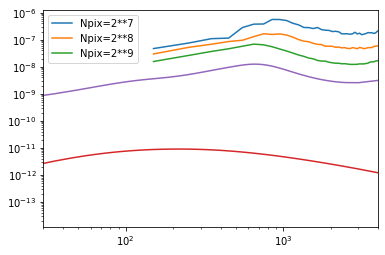

In [74]:
plt.loglog(kBins[1:], omega_g_7[1:], label="Npix=2**7")
plt.loglog(kBins[1:], omega_g_8[1:], label="Npix=2**8")
plt.loglog(kBins[1:], omega_g_9[1:], label="Npix=2**9")
plt.loglog(omega_Ls, omega_ps)
plt.loglog(omega_Ls, omega_ps/F_L_spline_g(omega_Ls))
plt.xlim(3e1, 4e3)
# plt.ylim(1e-9,1e-6)
plt.legend()

In [18]:
F_L_spline_k = F_L_spline

In [128]:
fields = "k"
fields = np.char.array(list(fields))
Lmin = 30
Lmax = 4000
Nells = 150
sample_Ls = fish.covariance.get_log_sample_Ls(Lmin=Lmin, Lmax=Lmax, Nells=Nells)
sample_Ls, F_L, C_inv = fish.get_F_L(fields, Ls=sample_Ls, Ntheta=100, nu=353e9, return_C_inv=True)
F_L_spline_30_4000_150 = InterpolatedUnivariateSpline(sample_Ls, F_L)

(30.0, 5000.0)

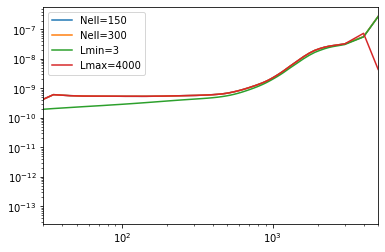

In [129]:
plt.loglog(omega_Ls, omega_ps/F_L_spline_30_5000_150(omega_Ls), label="Nell=150")
plt.loglog(omega_Ls, omega_ps/F_L_spline_30_5000_300(omega_Ls), label="Nell=300")
plt.loglog(omega_Ls, omega_ps/F_L_spline_3_5000_150(omega_Ls), label="Lmin=3")
plt.loglog(omega_Ls, omega_ps/F_L_spline_30_4000_150(omega_Ls), label="Lmax=4000")
plt.legend()
plt.xlim(3e1, 5e3)